<h1>Design and Simulation of a Grid Forming Inverter</h1>
<h2>System definition</h2>
<p>This notebook presents the complete design and verification of an inverter working as grid forming</p>

In [1]:
clear all

% Set the Octave Engine to run the simulation
SetSimulationEnvironment;


% Input Data

Rf = 0.1
Lf = 0.01

Rc = 0.01
Cf = 0.001

Rl = 10
Ll = 0.1

om = 2*pi*50

Vref = sqrt(3)*220

Rf =  0.10000
Lf =  0.010000
Rc =  0.010000
Cf =  0.0010000
Rl =  10
Ll =  0.10000
om =  314.16
Vref =  381.05


<h2>Current Loop</h2>
<p>First thing we design the current loop compensating the pole of the inductance and fixing the bandwidth</p>

In [2]:
ombc = 600*2*pi

Kpc = ombc*Lf
Kic = ombc*Rf

ombc =  3769.9
Kpc =  37.699
Kic =  376.99


<p>As result we have the following frequency responses</p>
<p>Open loop current</p>


Transfer function 'Gc' from input 'u1' to output ...

           1      
 y1:  ------------
      0.01 s + 0.1

Continuous-time model.


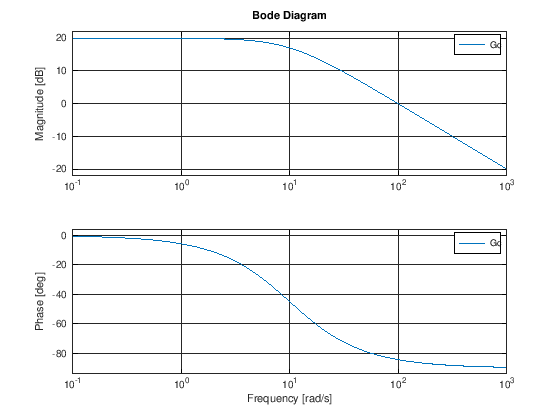

In [3]:
Gc = tf(1,[Lf Rf])
bode(Gc)

<p>Adding the controller to the open loop</p>


Transfer function 'Rcur' from input 'u1' to output ...

      37.7 s + 377
 y1:  ------------
           s      

Continuous-time model.

Transfer function 'Gopenc' from input 'u1' to output ...

        37.7 s + 377  
 y1:  ----------------
      0.01 s^2 + 0.1 s

Continuous-time model.


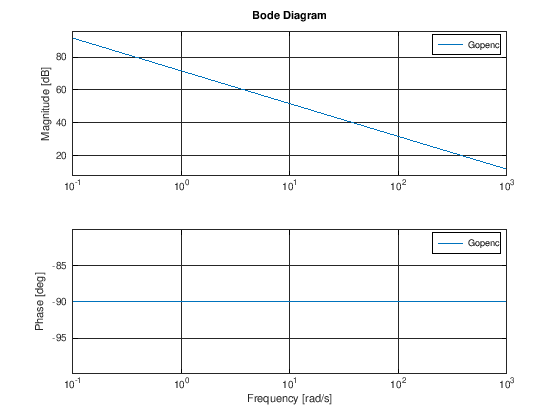

In [4]:
Rcur = tf([Kpc Kic],[1 0])
Gopenc = Rcur*Gc
bode(Gopenc)

<h2>Voltage Loop</h2>
<p>The design is performed by tuning the PI control and assuming that ESR does not play a role and that the current loop is too fast for the voltage loop</p>

In [5]:
ombv = 100*2*pi
fim = 60*pi/180

Gv = tf(1,[Cf 0])

[Go Fo]= bode(Gv,ombv)
Fo = Fo*pi/180;

Kpv = cos(-pi+fim-Fo)/Go
Kiv = -sin(-pi+fim-Fo)*ombv/Go


ombv =  628.32
fim =  1.0472

Transfer function 'Gv' from input 'u1' to output ...

         1   
 y1:  -------
      0.001 s

Continuous-time model.
Go =  1.5915
Fo = -90
Kpv =  0.54414
Kiv =  197.39



Transfer function 'Rv' from input 'u1' to output ...

      0.5441 s + 197.4
 y1:  ----------------
             s        

Continuous-time model.

Transfer function 'Gopenv' from input 'u1' to output ...

      0.5441 s + 197.4
 y1:  ----------------
         0.001 s^2    

Continuous-time model.


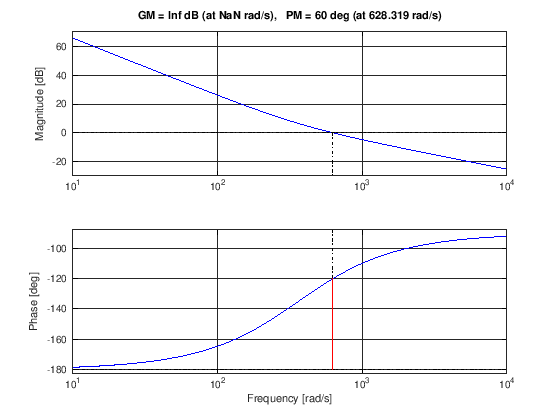

In [6]:
Rv = tf([Kpv Kiv],[1 0])
Gopenv = Rv*Gv
margin(Gopenv)

In [7]:
% Set the Octave Engine to run the simulation
SetSimulationEnvironment;

tini = 0;
tfinal = 0.1;
dt = 0.0001;
nflows = 44;
nnode = 23;
maxn = 20;
toll = 0.0001;

% Creating an hybrid diagram containing a power network and control
hy = HybridSystem(nnode,nflows,tini,tfinal,dt,maxn,toll);

% POWER NETWORK TOPOLOGY - Inverter+Filter+Load
% Voltage Source
c1{1} = Signal2Source(1,0,24);
c1{2} = Signal2Source(2,0,25);
c1{3} = Signal2Source(3,0,26);

% Resistor
c1{4} = Resistance(1,4,Rf);
c1{5} = Resistance(2,5,Rf);
c1{6} = Resistance(3,6,Rf);

% Inductor
c1{7} = Inductor(4,7,Lf);
c1{8} = Inductor(5,8,Lf);
c1{9} = Inductor(6,9,Lf);

% Current Sensors
c1{10} = CurrentSensor(7,10,29);
c1{11} = CurrentSensor(8,11,30);
c1{12} = CurrentSensor(9,12,31);

% Capacitor Resistances
c1{13} = Resistance(10,20,Rc);
c1{14} = Resistance(11,21,Rc);
c1{15} = Resistance(12,22,Rc);

% Capacitor Filter
c1{16} = Capacitor(20,23,Cf);
c1{17} = Capacitor(21,23,Cf);
c1{18} = Capacitor(22,23,Cf);

% Line/Load Resistance
c1{19} = Resistance(10,13,Rl);
c1{20} = Resistance(11,14,Rl);
c1{21} = Resistance(12,15,Rl);

% Line/Load Inductor
c1{22} = Inductor(13,16,Ll);
c1{23} = Inductor(14,17,Ll);
c1{24} = Inductor(15,18,Ll);

% Current sensors on line
c1{25} = CurrentSensor(16,19,34);
c1{26} = CurrentSensor(17,19,35);
c1{27} = CurrentSensor(18,19,36);

% Voltage sensors across capacitors
c1{28} = VoltageSensor(10,23,39);
c1{29} = VoltageSensor(11,23,40);
c1{30} = VoltageSensor(12,23,41);

% Adding all the components to the Control Schema
hy.AddListComponents2Network(c1);

% CONTROL SYSTEM
% Voltage Control
b1{1} = Constant(1,Vref);
b1{2} = Constant(2,0);
b1{3} = Sum(1,42,3,1,-1);
b1{4} = Sum(2,43,4,1,-1);
b1{5} = PI(3,5,Kpv,Kiv,0);
b1{6} = PI(4,6,Kpv,Kiv,0);

% Feedforward and decoupling voltage loop
b1{7} = Sum(5,8,9,1,1);
b1{8} = Sum(6,7,10,1,-1);
b1{9} = Gain(43,8,2*pi*50*Cf);
b1{10} = Gain(42,7,2*pi*50*Cf);
b1{11} = Sum(9,37,11,1,1);
b1{12} = Sum(10,38,12,1,1);

% Current Control
b1{13} = Sum(11,32,13,1,-1);
b1{14} = Sum(12,33,14,1,-1);
b1{15} = PI(13,15,Kpc,Kic,0);
b1{16} = PI(14,17,Kpc,Kic,0);

% Feedforward and decoupling current loop
b1{17} = Sum(15,16,19,1,1);
b1{18} = Sum(17,18,20,1,-1);
b1{19} = Gain(33,16,2*pi*50*Lf);
b1{20} = Gain(32,18,2*pi*50*Lf);
b1{21} = Sum(19,42,21,1,1);
b1{22} = Sum(20,43,22,1,1);

% Park Output Voltage Reference
b1{23} = InvPark(21,22,2,24,25,26,23);

% Angle Reference
b1{24} = Constant(27,2*pi*50);
b1{25} = Integrator(27,23,0);

% Measurement Current Filter
b1{26} = Park(29,30,31,32,33,44,23);

% Measurement Voltage Filter
b1{27} = Park(39,40,41,42,43,44,23);

% Measurement Current Load
b1{28} = Park(34,35,36,37,38,44,23);


% Adding all the components to the Control Schema
hy.AddListComponents2Schema(b1);



% Initialization
hy.Init();
p=1;

% Simulation Loop
while hy.Step()
    time(p) = hy.GetTime();
    
    % Park Voltage
    out(1,p) = hy.GetFlow(42);
    out(2,p) = hy.GetFlow(43); 
    
    % Park Currents
    out(3,p) = hy.GetFlow(32); 
    out(4,p) = hy.GetFlow(33); 
    
    % Phase Voltages
    out(5,p) = hy.GetFlow(39);
    out(6,p) = hy.GetFlow(40);
    out(7,p) = hy.GetFlow(41);
    
    % Phase Currents
    out(8,p) = hy.GetFlow(34);
    out(9,p) = hy.GetFlow(35);
    out(10,p) = hy.GetFlow(36);
    
    p=p+1;
end


<p>Park Voltages on the filter</p>

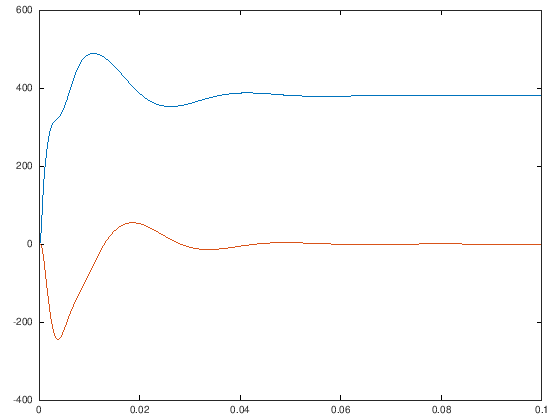

In [8]:
plot(time,out(1,:),time,out(2,:));  

<p>Park Currents on the filter</p>

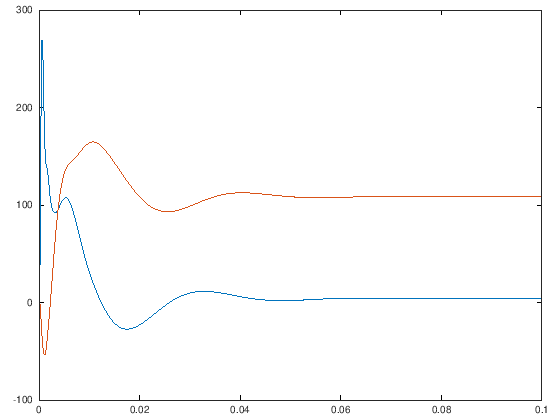

In [9]:
plot(time,out(3,:),time,out(4,:));

<p>Phase voltages</p>

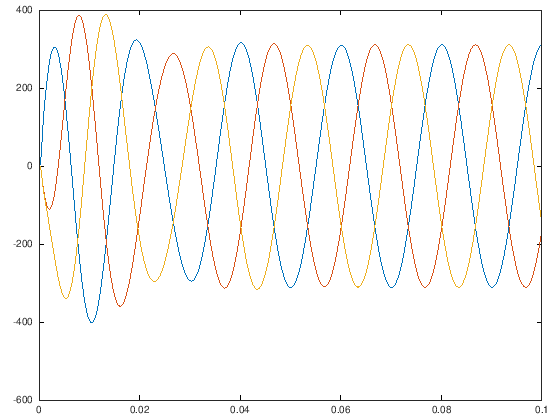

In [10]:
plot(time,out(5,:),time,out(6,:),time,out(7,:));   

<p>Phase currents</p>

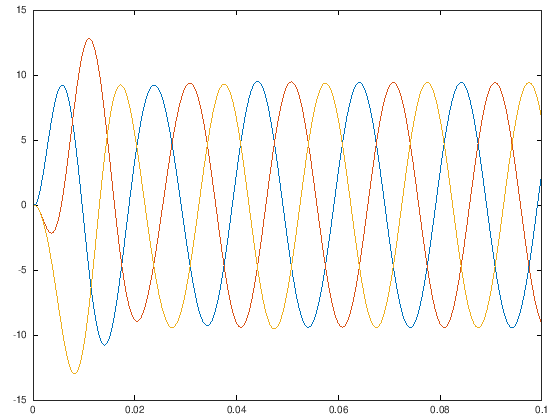

In [11]:
plot(time,out(8,:),time,out(9,:),time,out(10,:));

<h2>State Feedback with integrator</h2>
<p>We approach now the design in the state space domain</p>
<p>First thing we need to define the system matrices as state space matrices</p>



In [12]:
Ass = [-Rf/Lf om -1/Lf 0; -om -Rf/Lf 0 -1/Lf; 1/Cf 0 0 om; 0 1/Cf -om 0]
Bss = [1/Lf 0; 0 1/Lf; 0 0; 0 0]

Ass =

    -10.00000    314.15927   -100.00000      0.00000
   -314.15927    -10.00000      0.00000   -100.00000
   1000.00000      0.00000      0.00000    314.15927
      0.00000   1000.00000   -314.15927      0.00000

Bss =

   100     0
     0   100
     0     0
     0     0



<p>We assume not to measure the current of the load and we treat it as a disturbance</p>
<p>As result we need to add an integrator and extend the system matrices of one order to track vd</p>

In [13]:
C = [0 0 1 0;0 0 0 1] 
Asse = [Ass zeros(4,2);-C zeros(2,2)] 
Bsse = [Bss; zeros(2,2)]

C =

   0   0   1   0
   0   0   0   1

Asse =

    -10.00000    314.15927   -100.00000      0.00000      0.00000      0.00000
   -314.15927    -10.00000      0.00000   -100.00000      0.00000      0.00000
   1000.00000      0.00000      0.00000    314.15927      0.00000      0.00000
      0.00000   1000.00000   -314.15927      0.00000      0.00000      0.00000
     -0.00000     -0.00000     -1.00000     -0.00000      0.00000      0.00000
     -0.00000     -0.00000     -0.00000     -1.00000      0.00000      0.00000

Bsse =

   100     0
     0   100
     0     0
     0     0
     0     0
     0     0



<p>We design a pole placement controller</p>

In [14]:
p1 = -100+1j*50;
p2 = -100-1j*50;
p3 = -100+1j*50;
p4 = -100-1j*50;
p5 = -1000;
p6 = -1000;


K = place(Asse,Bsse,[p1 p2 p3 p4 p5 p6])

K =

   1.1900e+01   6.2832e+00   1.3804e-01   3.7699e+00  -1.2500e+02   5.2905e-13
  -6.2832e+00   1.1900e+01  -3.7699e+00   1.3804e-01   5.2367e-13  -1.2500e+02



<p>We can now verify in simulation</p>

In [24]:
tini2 = 0;
tfinal2 = 0.1;
dt2 = 0.0001;
nflows2 = 44;
nnode2 = 23;
maxn2 = 20;
toll2 = 0.0001;

% Creating an hybrid diagram containing a power network and control
hy2 = HybridSystem(nnode2,nflows2,tini2,tfinal2,dt2,maxn2,toll2);

% POWER NETWORK TOPOLOGY - Inverter+Filter+Load
% Voltage Source
c2{1} = Signal2Source(1,0,24);
c2{2} = Signal2Source(2,0,25);
c2{3} = Signal2Source(3,0,26);

% Resistor
c2{4} = Resistance(1,4,Rf);
c2{5} = Resistance(2,5,Rf);
c2{6} = Resistance(3,6,Rf);

% Inductor
c2{7} = Inductor(4,7,Lf);
c2{8} = Inductor(5,8,Lf);
c2{9} = Inductor(6,9,Lf);

% Current Sensors
c2{10} = CurrentSensor(7,10,29);
c2{11} = CurrentSensor(8,11,30);
c2{12} = CurrentSensor(9,12,31);

% Capacitor Resistances
c2{13} = Resistance(10,20,Rc);
c2{14} = Resistance(11,21,Rc);
c2{15} = Resistance(12,22,Rc);

% Capacitor Filter
c2{16} = Capacitor(20,23,Cf);
c2{17} = Capacitor(21,23,Cf);
c2{18} = Capacitor(22,23,Cf);

% Line/Load Resistance
c2{19} = Resistance(10,13,Rl);
c2{20} = Resistance(11,14,Rl);
c2{21} = Resistance(12,15,Rl);

% Line/Load Inductor
c2{22} = Inductor(13,16,Ll);
c2{23} = Inductor(14,17,Ll);
c2{24} = Inductor(15,18,Ll);

% Current sensors on line
c2{25} = CurrentSensor(16,19,34);
c2{26} = CurrentSensor(17,19,35);
c2{27} = CurrentSensor(18,19,36);

% Voltage sensors across capacitors
c2{28} = VoltageSensor(10,23,39);
c2{29} = VoltageSensor(11,23,40);
c2{30} = VoltageSensor(12,23,41);

% Adding all the components to the network diagram
hy2.AddListComponents2Network(c2);

% CONTROL SYSTEM
% Voltage Control
b2{1} = Constant(1,Vref);
b2{2} = Sum(1,42,2,1,-1);
b2{3} = Integrator(2,3,0);

b2{4} = Constant(4,0);
b2{5} = Sum(4,43,5,1,-1);
b2{6} = Integrator(5,6,0);

b2{7} = Gain([32 33 42 43 3 6],21,-K(1,:));
b2{8} = Gain([32 33 42 43 3 6],22,-K(2,:));

% Park Output Voltage Reference
b2{9} = InvPark(21,22,4,24,25,26,23);

% Angle Reference
b2{10} = Constant(27,2*pi*50);
b2{11} = Integrator(27,23,0);

% Measurement Current Filter
b2{12} = Park(29,30,31,32,33,44,23);

% Measurement Voltage Filter
b2{13} = Park(39,40,41,42,43,44,23);

% Measurement Current Load
b2{14} = Park(34,35,36,37,38,44,23);

% Adding all the components to the Control Schema
hy2.AddListComponents2Schema(b2);

% Initialization
hy2.Init();
p=1;

% Simulation Loop
while hy2.Step()
    time2(p) = hy2.GetTime();
    
    % Park Voltage
    out2(1,p) = hy2.GetFlow(42);
    out2(2,p) = hy2.GetFlow(43); 
    
    % Park Currents
    out2(3,p) = hy2.GetFlow(32); 
    out2(4,p) = hy2.GetFlow(33); 
    
    % Phase Currents
    out2(5,p) = hy2.GetFlow(34);
    out2(6,p) = hy2.GetFlow(35);
    out2(7,p) = hy2.GetFlow(36);
    
    p=p+1;
end



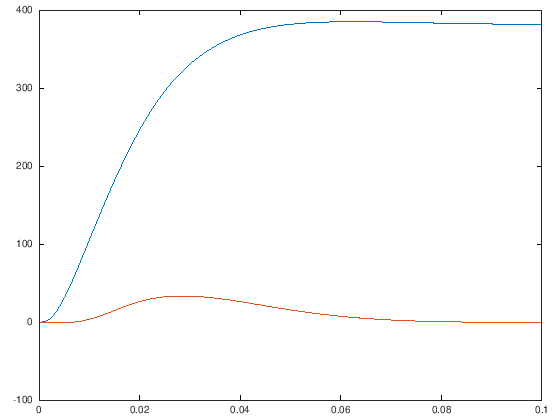

In [25]:
plot(time2,out2(1,:),time2,out2(2,:)); 

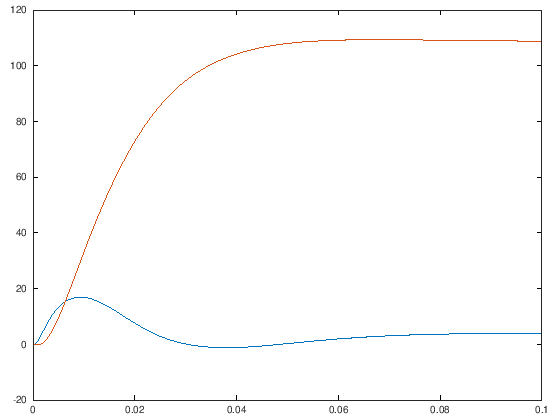

In [26]:
plot(time2,out2(3,:),time2,out2(4,:));

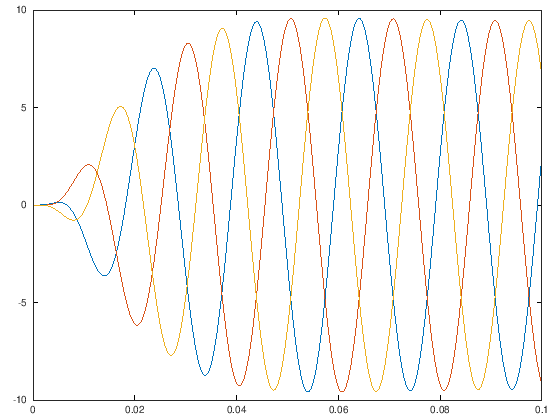

In [27]:
plot(time2,out2(5,:),time2,out2(6,:),time2,out2(7,:));